In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
tf.random.set_seed(52)

# Saliency Maps For Convolution Neural Networks

Load up mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

One hot encode labels array

In [3]:
nb_classes = 10
y_train = np.array(y_train).reshape(-1)
y_train = np.eye(nb_classes)[y_train]
y_test = np.array(y_test).reshape(-1)
y_test = np.eye(nb_classes)[y_test]

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [4]:
x_train.shape,x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Train a simple cnn with single convolution layer.

In [5]:
def build_model_conv(
    input_shape
):
    inputs = keras.Input(shape=input_shape)
    x1 = layers.Conv2D(3,(3,3),activation='relu',data_format="channels_last",padding='same',use_bias=False)(inputs)
    x1 = layers.MaxPooling2D(6)(x1)
    x = layers.Flatten()(x1)
    outputs = layers.Dense(10, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

model = build_model_conv(
    x_train.shape[1:],
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()],
)

model.summary()

model.fit(
    x_train,
    y_train,
    validation_data=[x_test,y_test],
    epochs=50,
    batch_size=100,
)

model.evaluate(x_test, y_test, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 3)         27        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 3)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 10)                490       
                                                                 
Total params: 517
Trainable params: 517
Non-trainable params: 0
_______________________________________________________________


KeyboardInterrupt



Find convolution layers.

In [6]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 conv2d (None, 28, 28, 3)


In [7]:
X_blind = x_test
y_blind = y_test
y_blind =y_test

plot saliency maps

Input Image


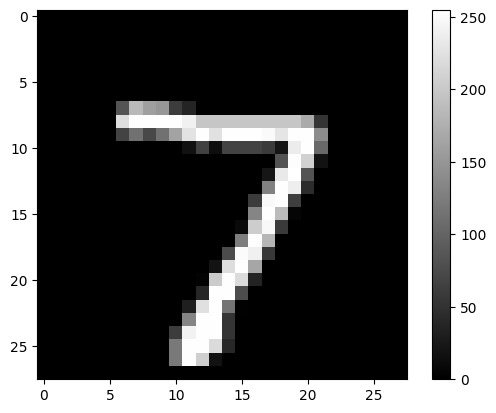

1/1 [==============================] - 0s 31ms/step
Filter Count: 3
Filter: 0
1/1 [==============================] - 0s 40ms/step
Filter: 1
1/1 [==============================] - 0s 41ms/step
Filter: 2
1/1 [==============================] - 0s 39ms/step


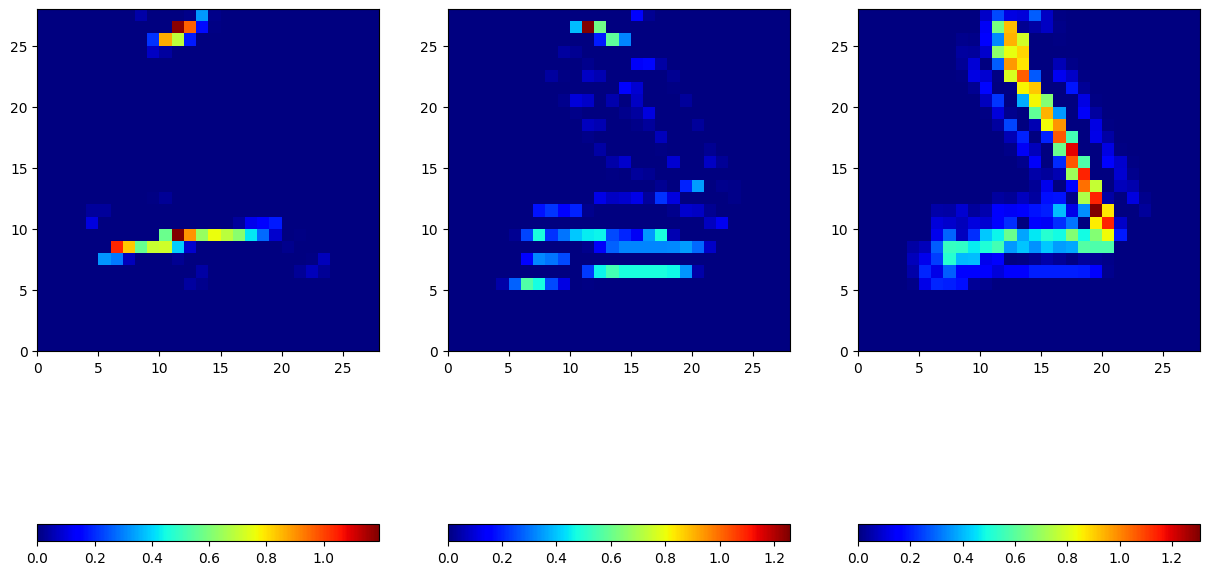

Input Image


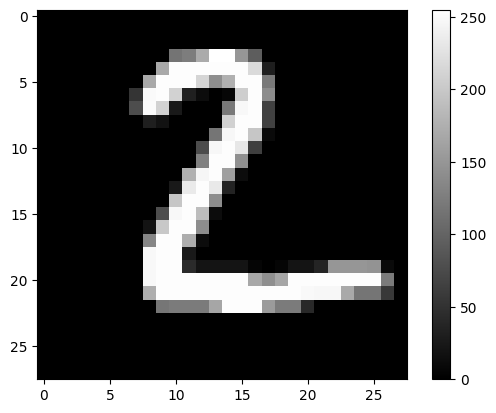

1/1 [==============================] - 0s 15ms/step
Filter Count: 3
Filter: 0
1/1 [==============================] - 0s 39ms/step
Filter: 1
1/1 [==============================] - 0s 38ms/step
Filter: 2
1/1 [==============================] - 0s 38ms/step


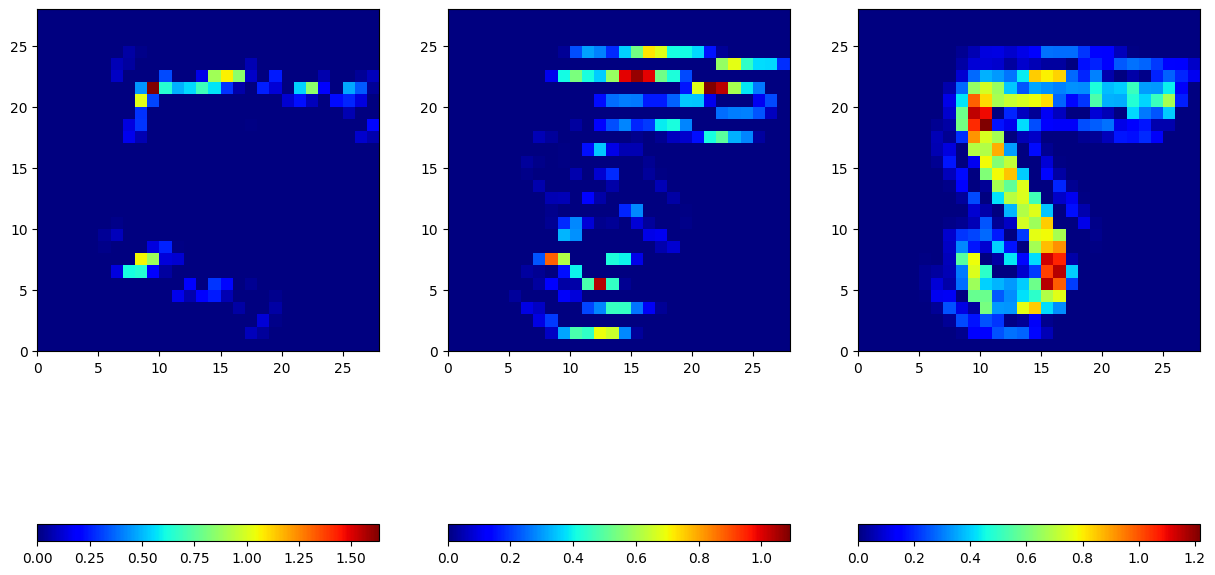

Input Image


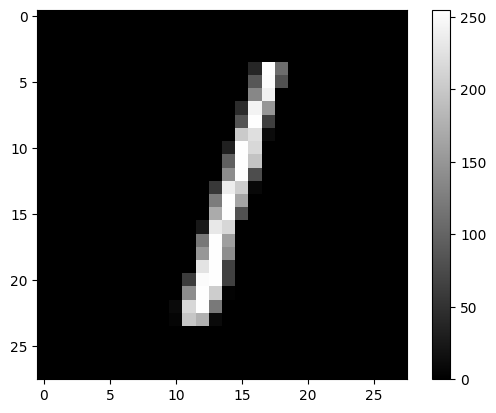

1/1 [==============================] - 0s 16ms/step
Filter Count: 3
Filter: 0
1/1 [==============================] - 0s 39ms/step
Filter: 1
1/1 [==============================] - 0s 39ms/step
Filter: 2
1/1 [==============================] - 0s 39ms/step


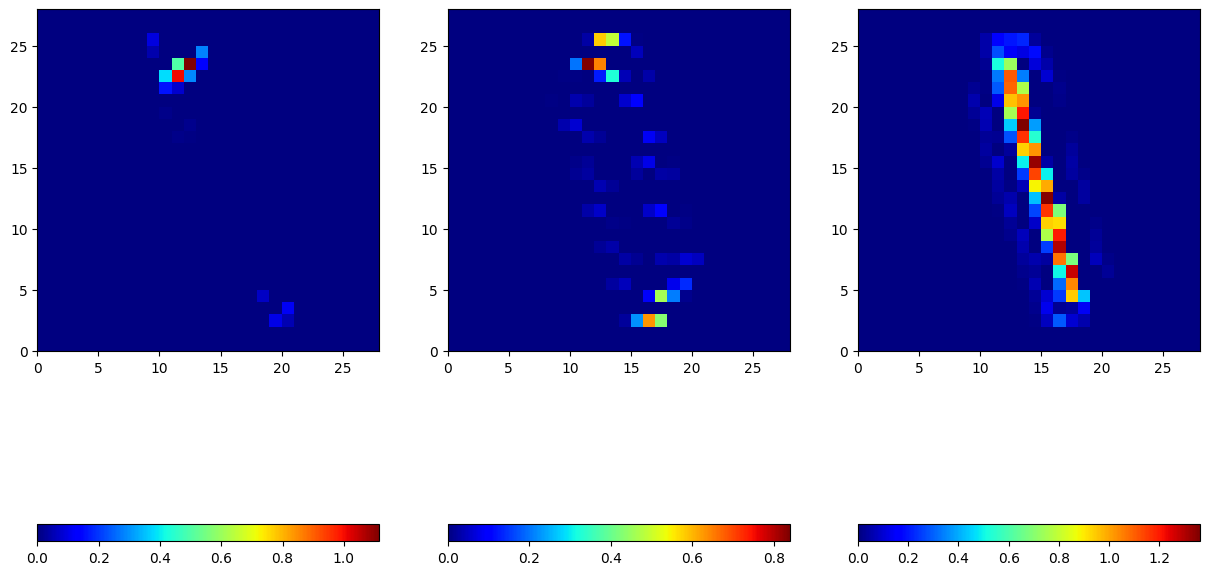

Input Image


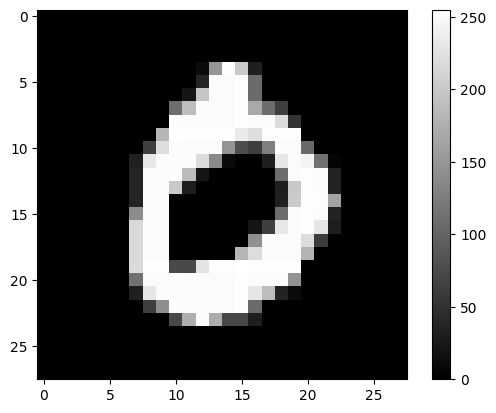

1/1 [==============================] - 0s 16ms/step
Filter Count: 3
Filter: 0


In [ ]:
from matplotlib import cm as CM
from keras.models import Model
from matplotlib import gridspec

model_fm = Model(inputs=model.inputs, outputs=model.layers[1].output)
for i in range(0,300):
    print('Input Image')
    sample = X_blind[i:i+1].reshape(-1,28,28,1)
    plt.imshow(sample.reshape(28,28,1), cmap='gray')
    plt.colorbar()
    plt.show()
    
    #weight extraction
    feature_maps = model_fm.predict(sample)
    w = model_fm.layers[1].get_weights()
    channel_count = feature_maps.shape[3]
    
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    gs0 = gridspec.GridSpec(1,3, figure=fig,hspace=0)

    print('Filter Count:',channel_count)
    for i in range(channel_count):
        
        print('Filter:',i)
        inp =  keras.Input(shape=(28,28,1))
        output= layers.Conv2DTranspose(1, (3,3),activation='relu',data_format="channels_last",padding='same',use_bias=False)(inp)
        model_network = Model(inputs=inp, outputs=output)
        model_network.layers[1].set_weights([w[0][:,:,:,i:i+1]])
        feature_maps_R = model_network.predict(feature_maps[:,:,:,i:i+1])
        
        ax1=fig.add_subplot(gs0[0,i])
        
        for z in range(1):  
            pcm = ax1.pcolormesh(feature_maps_R[:,:,:,z].reshape(28,28),cmap=CM.jet)
            ax1.set_aspect(1)

        fig.colorbar(pcm, ax=ax1,orientation="horizontal",location='bottom')


    plt.show()
